# Лабораторная работа 6. 
# Сетевые алгоритмы. Динамические алгоритмы поиска путей.


## Выполнил студент группы Семенов Андрей Владиславович БФИ2001
***

### Задание

1.  Реализовать алгоритм поиска кратчайшего расстояния между двумя вершинами ориентированного взвешенного графа в соответствии с вариантом. 

2.  Предусмотреть задание графа в виде матрицы смежности/инцидентности, читаемой из файла, либо графически с помощью пользовательского интерфейса. 

3.  Разработать графический интерфейс пользователя с визуализацией графа и отображением кратчайшего расстояния между задаваемыми пользователем вершинами.

4. По результатам работы проанализировать временную сложность работы заданного алгоритма в зависимости от числа узлов и ребер графа.
Данные представить в виде таблицы.



### Алгоритмы:

Алгоритм Флойда-Уоршелла| Алгоритм Дейкстры | Алгоритм Беллмана-Форда | Алгоритм Джонсона| Алгоритм Левита | Алгоритм Йена



### Выполнение:

In [1]:
from collections import  deque
from typing import Any, NamedTuple, Optional, Type
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
INF = 9999

In [3]:
class ShortestPath(NamedTuple):
    total_weight: float
    path: list[Any]
    all_paths: dict[Any, float] = {}

In [4]:
class GraphException(Exception): pass

In [5]:
class Graph(nx.DiGraph):
    @property
    def adj_matrix(self) -> list[list[int]]:
        matrix = nx.adjacency_matrix(self).toarray()

        for i in range(len(matrix)):
            for j in range(len(matrix)):
                if i != j and matrix[i][j] == 0:
                    matrix[i][j] = INF

        return matrix

    def display(self, path: Optional[list[Any]] = None) -> None:
        pos = nx.shell_layout(self)
        plt.figure(num=None, figsize=(10, 10), dpi=80)
        edge_labels = dict([
            ((u, v), c["weight"])
            for (u, v, c) in self.edges(data=True)
        ])
        nx.draw_networkx_edge_labels(self, pos, edge_labels=edge_labels)
        nx.draw_networkx(self, pos, node_size=900, arrows=True, with_labels=True)

        if path is not None:
            path_edges: list[tuple[Any, Any]] = list(zip(path, path[1:]))
            nx.draw_networkx_nodes(self, pos, node_size=900, nodelist=path, node_color='r')
            nx.draw_networkx_edges(
                self, pos, edgelist=path_edges, edge_color='r')

        
        plt.show()

In [6]:
class FloydGraph(Graph):
    def floyd(self, start: Any, end: Any) -> ShortestPath:
        nodes: list[Any] = list(self.nodes)
        size: int = len(nodes)
        matrix: list[list[int]] = deepcopy(self.adj_matrix)
        paths: list[list[int]] = [
            [i for i in range(size)]
            for _ in range(size)
        ]

        for k in range(size):
            for i in range(size):
                for j in range(size):
                    if (summ := matrix[i][k] + matrix[k][j]) < matrix[i][j]:
                        matrix[i][j] = summ
                        paths[i][j] = paths[i][k]

        start_index: int = nodes.index(start)
        end_index: int = nodes.index(end)

        result_path = [start_index]
        while start_index != end_index:
            start_index = paths[start_index][end_index]
            result_path.append(start_index)

        return ShortestPath(
            paths[start_index][end_index],
            [list(self.nodes)[i] for i in result_path]
        )


In [7]:
class DijkstraGraph(Graph):
    def dijkstra(self, start: Any, end: Any = None) -> ShortestPath:
        nodes: list[Any] = list(self.nodes)
        size: int = len(nodes)
        matrix: list[list[int]] = self.adj_matrix

        current_node: int = nodes.index(start)
        paths: list[int] = [0] * size
        cache: set[int] = set([current_node])

        dist: list[float] = [INF] * size
        dist[current_node] = 0

        while current_node != -1:
            for i, iv in enumerate(matrix[current_node]):
                if i not in cache:
                    w = dist[current_node] + iv
                    if w < dist[i]:
                        dist[i] = w
                        paths[i] = current_node

            current_node = self._arg_min(dist, cache)

            if current_node >= 0:
                cache.add(current_node)

        total_weight: int = 0
        start_index: int = nodes.index(start)
        path: list[int] = []

        if end is not None:
            end_index: int = nodes.index(end)
            path.append(end_index)
            while end_index != start_index:
                end_index = paths[path[-1]]
                total_weight += matrix[end_index][path[-1]]
                path.append(end_index)
                if total_weight == INF:
                    break

        return ShortestPath(
            total_weight,
            [nodes[i] for i in path[::-1]],
            {nodes[i]: j for i, j in enumerate(dist)}
        )

    def _arg_min(self, dist: list[float], cache: set[int]) -> int:
        minimum: int = -1
        m: float = INF

        for i, t in enumerate(dist):
            if t < m and i not in cache:
                m: float = t
                minimum: int = i

        return minimum

In [8]:
class BellmanFordGraph(Graph):
    def bellman_ford(self, start: Any, end: Any = None) -> ShortestPath:
        nodes: list[Any] = list(self.nodes)
        size: int = len(nodes)

        weights: dict[Any, float] = {i : INF for i in nodes}
        weights[start] = 0

        paths = {j : i for i, j in self.edges}

        for _ in range(size):
            for i, j, w in self.edges(data=True):
                weight: int = w["weight"]

                if weights[i] < INF and (s := weights[i] + weight) < weights[j]:
                    weights[j] = s
                    paths[j] = i


        for i, j, w in self.graph:
            weight: int = w["wight"]
            if weights[i] < INF and weights[i] + weight < weights[j]:
                raise GraphException("Negative cycle found")

        if end is None:
            return ShortestPath(0, [], weights)
        else:
            result_paths: list[Any] = []
            current: Any = end

            while True:
                result_paths.append(current)
                if current == start:
                    break
                current = paths[current]

            return ShortestPath(weights[end], result_paths[::-1])

In [9]:
class JohnsonGraph(BellmanFordGraph, DijkstraGraph):
    def johnson(self, start: Any, end: Any) -> ShortestPath:
        results = []
        self.add_node('Q')
        for node in self.nodes:
            self.add_weighted_edges_from([('Q', node, 0)])

        ford_result: dict[Any, float] = self.bellman_ford('Q').all_paths

        for node in self.nodes:
            for neigh in self.neighbors(node):
                self.edges[node, neigh]["weight"] += \
                        ford_result[node] - ford_result[neigh]

        self.remove_node('Q')
        paths: dict = {}

        for node in self.nodes:
            d = self.dijkstra(node, end)
            paths[node] = d.all_paths
            results.append(d.path)

        for node1 in self.nodes:
            for node2 in self.nodes:
                paths[node1][node2] += ford_result[node2] - ford_result[node1]

        for node in self.nodes:
            for neigh in self.neighbors(node):
                self.edges[node, neigh]["weight"] += \
                        ford_result[neigh] - ford_result[node]

        return ShortestPath(
            paths[start][end],
            results[list(self.nodes).index(start)]
        )


In [10]:
class LevitGraph(Graph):
    def levit(self, start: Any, end: Any) -> ShortestPath:
        d = {node: INF for node in self.nodes}
        d[start] = 0
        cache = deque([start])
        state = {node: 2 for node in self.nodes}
        state[start] = 1
        p = {node: -1 for node in self.nodes}

        while cache:
            vertex: Any = cache.popleft()
            state[vertex] = 0
            for neigh in self.neighbors(vertex):
                weight = self.edges[vertex, neigh]["weight"]
                if (sum_ := d[vertex] + weight) < d[neigh]:
                    d[neigh] = sum_
                    if state[neigh] == 2:
                        cache.append(neigh)
                    elif state[neigh] == 0:
                        cache.appendleft(neigh)
                    p[neigh] = vertex
                    state[neigh] = 1

        path = []
        vertex = end
        while vertex != -1:
            path.append(vertex)
            vertex = p[vertex]

        return ShortestPath(d[end], path[::-1])

In [11]:
class YenGraph(DijkstraGraph):
    def yen(self, start: Any, end: Any, top_paths: int = 3) -> list[ShortestPath]:
        paths: list[Any] = [[] for _ in range(top_paths)]
        d = self.dijkstra(start, end)
        paths[0] = d.path

        candidates: dict[float, list[Any]] = {}

        for k in range(1, top_paths):

            for i, spur in enumerate(paths[k-1][:-1]):
                removed_edges: list[tuple[Any, Any]] = []
                removed_nodes: list[Any] = []

                root_path: list[Any] = paths[k-1][:i+1]

                for path in paths:
                    if root_path == path[:i+1]:
                        edges: tuple[Any, Any] = path[i], path[i+1]
                        if edges in self.edges:
                            self.remove_edge(*edges)
                            removed_edges.append(edges)

                for node in root_path:
                    if node != spur:
                        self.remove_node(node)
                        removed_nodes.append(node)

                spur_path = self.dijkstra(spur, end)

                total_path = root_path + spur_path.path[1:]

                if spur_path not in candidates.values():
                    candidates[spur_path.total_weight] = total_path

                for node in removed_nodes:
                    self.add_node(node)

                for edge in removed_edges:
                    self.add_edge(*edge)

            if not candidates:
                break

            min_weight: float = min(list(candidates.keys()))
            paths[k] = candidates[min_weight]
            del candidates[min_weight]

        return paths


In [12]:
def generate_graph(graph_type: Type[Graph]) -> Graph:
    g: Graph = graph_type()
    g.add_nodes_from("ABCDEFGH")
    g.add_weighted_edges_from([
        ('A', 'B', 2),
        ('A', 'D', 3),
        ('A', 'E', 5),
        ('A', 'H', 10),
        ('B', 'C', 4),
        ('D', 'H', 8),
        ('E', 'F', 2),
        ('F', 'G', 3),
        ('G', 'H', 1)
    ])

    return g


In [13]:
def generate_graph(graph_type: Type[Graph]) -> Graph:
    g: Graph = graph_type()
    g.add_nodes_from("ABCDEFGH")
    g.add_weighted_edges_from([
        ('A', 'B', 2),
        ('A', 'D', 3),
        ('A', 'E', 5),
        ('A', 'H', 10),
        ('B', 'C', 4),
        ('D', 'H', 8),
        ('E', 'F', 2),
        ('F', 'G', 3),
        ('G', 'H', 1)
    ])


    return g


## Алгоритм Флойда-Уоршелла

/tmp/ipykernel_136245/1598142317.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  matrix = nx.adjacency_matrix(self).toarray()


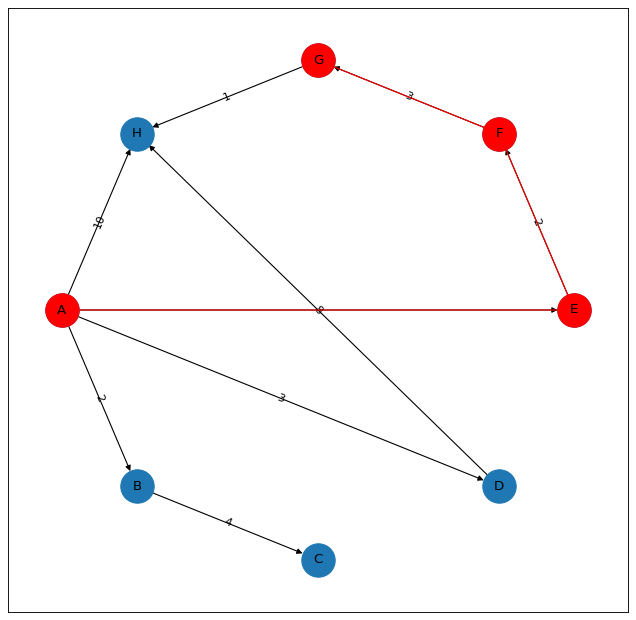

In [14]:
g = generate_graph(FloydGraph)
res = g.floyd('A', 'G')
g.display(res.path)

## Алгоритм Дейкстры

/tmp/ipykernel_136245/1598142317.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  matrix = nx.adjacency_matrix(self).toarray()


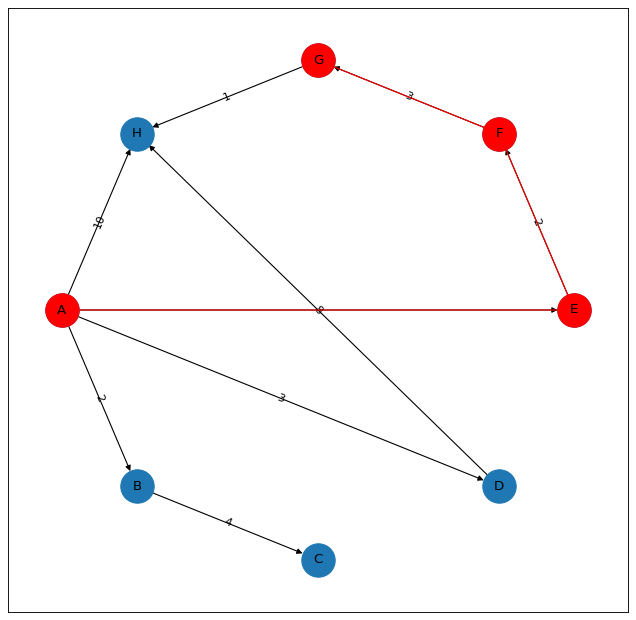

In [15]:
g = generate_graph(DijkstraGraph)
res = g.dijkstra('A', 'G')
g.display(res.path)

## Алгоритм Беллмана-Форда

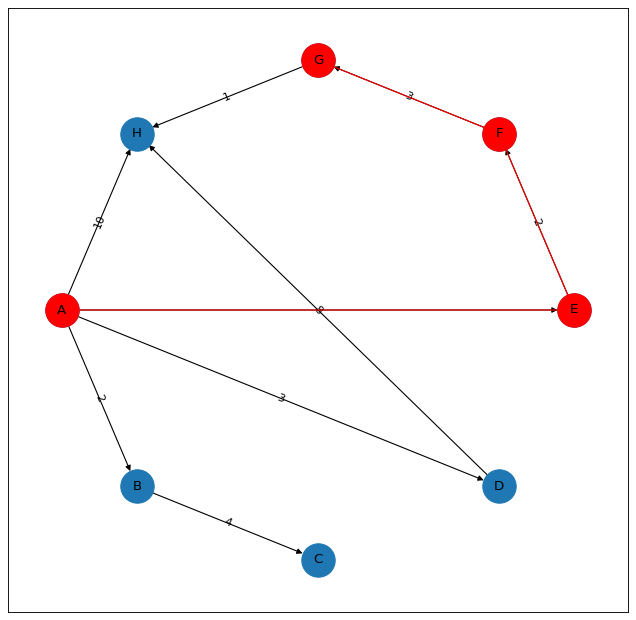

In [16]:
g = generate_graph(BellmanFordGraph)
res = g.bellman_ford('A', 'G')
g.display(res.path)

## Алгоритм Джонсона

/tmp/ipykernel_136245/1598142317.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  matrix = nx.adjacency_matrix(self).toarray()


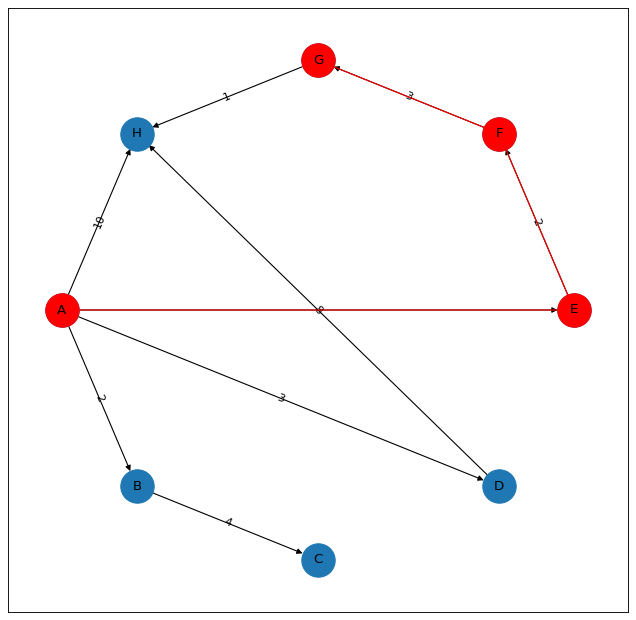

In [17]:
g = generate_graph(JohnsonGraph)
res = g.johnson('A', 'G')
g.display(res.path)

## Алгоритм Левита

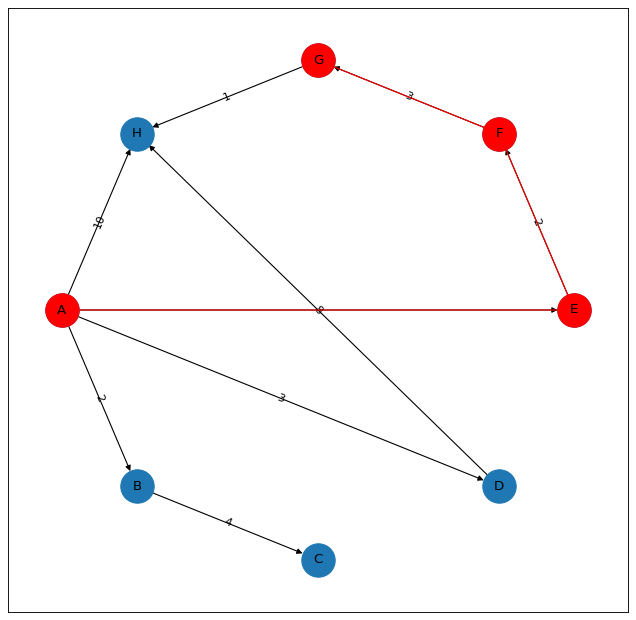

In [18]:
g = generate_graph(LevitGraph)
res = g.levit('A', 'G')
g.display(res.path)

## Алгоритм Йена

/tmp/ipykernel_136245/1598142317.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  matrix = nx.adjacency_matrix(self).toarray()


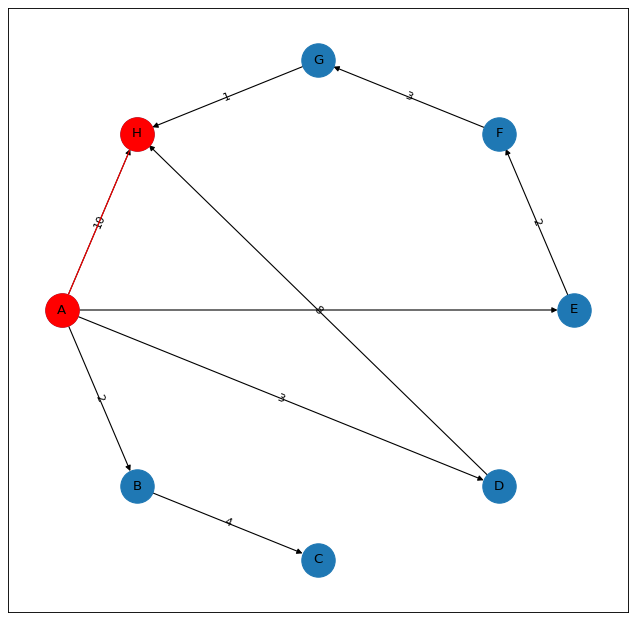

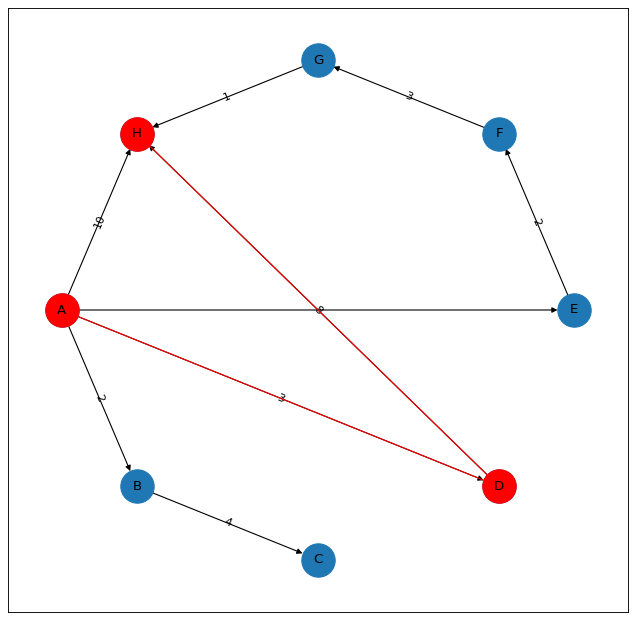

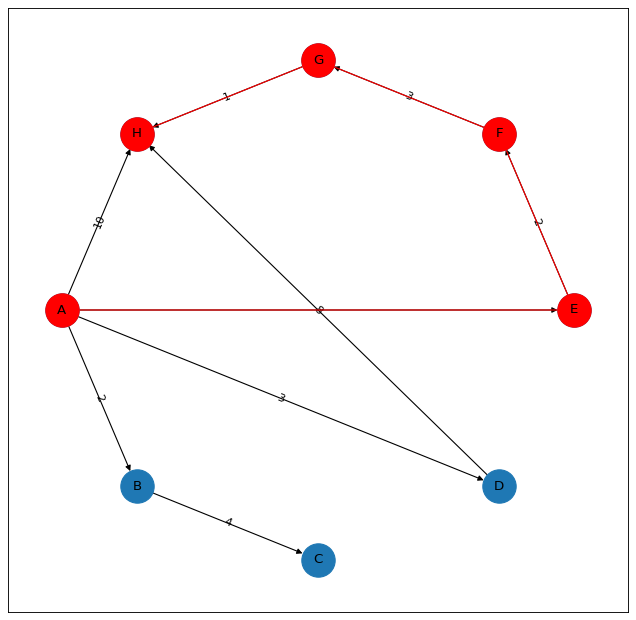

In [19]:
g = generate_graph(YenGraph)
results = g.yen('A', 'H')
for res in results:
    generate_graph(YenGraph).display(res)

### Вывод

В данной лабораторной работе были рассмотрены алгоритмы поиска кратчайшего пути в взвешенных ориентированных графах.

### Временная сложность

Название алгоритма       | Временная сложность |
------------------------ | ------------------- |
Алгоритм Флойда-Уоршелла | O($n^3$)  
Алгоритм Дейкстры        | O($n^2$) 
Алгоритм Беллмана-Форда  | O($nodes * edges$) 
Алгоритм Джонсона        | O($nodes * edges * logV$)
Алгоритм Левита          | O($nodes * edges$)
Алгоритм Йена            | O($n^2$)